#IMPORTS

---



In [2]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd ./drive/My\ Drive/vp_project

# Some imports
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os, random

# Library for create patches of an image
!pip install patchify
from patchify import patchify, unpatchify

# Library for reading the EXIF meta-data
!pip install exifread
import exifread
import json
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
!pip install patchify
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import os, random
import exifread

import json
import seaborn as sns

Mounted at /content/drive
[Errno 2] No such file or directory: './drive/My Drive/vp_project'
/content


#FUNCTIONS

---



In [11]:
# Find left-right or top-bottom padding value
def paddingParameters(n):
  n1 = n//2
  n2 = n1
  if (n%2 == 1):
    n2+=1 
  return n1, n2

# Return array of the image
def imRead(path):
  return np.array(Image.open(path))

# Return the patches array
def patches(image, size = 128):
  imageShape = np.shape(image)
  top, bottom = paddingParameters(size - (imageShape[0] % size))
  left, right = paddingParameters(size - (imageShape[1] % size))
  imageWithPadding = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
  patches = patchify(imageWithPadding, (size,size,3), step=size)
  return patches[:,:,0]

# Calculate the predictions for an image
def calculatePredictions(model, image_patch, imageShape):
  input_batch = {"left": [], "right": []}
  for i in range(imageShape[0]):
    for j in range(imageShape[1]):
      left_input = image_patch[i][j]
      input_L_preprocessed = tf.keras.applications.resnet50.preprocess_input(left_input)
      for x in range(imageShape[0]):
        for y in range(imageShape[1]):
          right_input = image_patch[x][y]
          input_R_preprocessed = tf.keras.applications.resnet50.preprocess_input(right_input)
          input_batch["left"].append(input_L_preprocessed)
          input_batch["right"].append(input_R_preprocessed)
  predicted = model.predict([np.array(input_batch["left"]), np.array(input_batch["right"])])
  return predicted

# Calculate the output image fixing one patch
def predictionPerPatch(predicted, imageShape):
  cont = 0
  prediction_patches = []
  predictions = np.zeros(imageShape)
  for i in range((imageShape[0] * imageShape[1])):
    for x in range(imageShape[0]):
      for y in range(imageShape[1]):
        predictions[x][y] = np.average(predicted[cont + imageShape[1]*x + y])
    prediction_patches.append(predictions)
    predictions = np.zeros(imageShape)
    cont += imageShape[0] * imageShape[1]
  return prediction_patches

# Calculate the output as a mean between all patch output 
def patchMean(prediction_patches, imageShape):
  output = np.zeros(imageShape)
  for value in prediction_patches:
    for x in range(imageShape[0]):
      for y in range(imageShape[1]):
        output[x][y] += value[x][y]/len(prediction_patches)
  return output

# Calculate threshold of the outputs
def threshold():
  meanThreshold = 0
  minThreshold = 2
  maxThreshold = -1
  for out in outputs:
    mean = np.average(out[0])
    filename = out[1][:-5]
    if (mean > maxThreshold):
      maxThreshold = mean
    if (mean < minThreshold):
      minThreshold = mean
    meanThreshold += mean
  meanThreshold = meanThreshold/len(outputs)
  return meanThreshold, minThreshold, maxThreshold

# SCORE FUNCTIONS
def recall(TP, FN):
  return TP/(TP + FN)

def precision(TP, FP):
  return TP/(TP + FP)

def calculate_TP_TN_FP_FN(threshold):
  TP = 0
  TN = 0
  FP = 0
  FN = 0
  for out in outputs:
    mean = np.average(out[0])
    filename = out[1][:-5]
    if (filename == "fake"):
      if (mean > threshold):
        FN += 1
      else:
        TN += 1
    if (filename == "real"):
      if (mean > threshold):
        TP += 1
      else:
        FP += 1
  return TP, TN, FP, FN

def f1():
  t, _, _ =  threshold()
  TP, _, FP, FN = calculate_TP_TN_FP_FN(t)
  return 2*TP/(2*TP + FN + FP)
    
def mcc():
  t, _, _ =  threshold()
  TP, TN, FP, FN = calculate_TP_TN_FP_FN(t)
  return ((TP * TN) - (FP * FN))/np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

def ap():
  _, mt, Mt =  threshold()
  thresholds = np.arange(start=mt, stop=Mt, step=(Mt - mt)/10)
  apSum = 0
  for k in range(len(thresholds)-1):
    TP1, _, FP1, FN1 = calculate_TP_TN_FP_FN(thresholds[k])
    TP2, _, _, FN2 = calculate_TP_TN_FP_FN(thresholds[k+1])
    apSum += (recall(TP1, FN1) - recall(TP2, FN2)) * precision(TP1, FP1)
  return apSum

In [13]:
ls

Exif/                    Model_Building_And_Training.ipynb
ExifFrequencies.json     modello_vecchio_sigmoid_crossentropy_e_4096_new/
filteredImagesExif.json  testDataset/
filteredImages.json      Test_Model__.ipynb
imagePerExifValue/


# MAIN CODE

---



## Load the model

In [14]:
model = keras.models.load_model('./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello400', compile=False)

##Calculate the outputs of the testset

In [ ]:
imageNumber = 1
outputs = []
directory = os.fsencode("./testDataset")
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  filenamePath = "./testDataset/" + filename  
  immagine_test = imRead(filenamePath)
  image_patch = patches(immagine_test,size=128)
  imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])
  imageNumber += 1
  predicted = calculatePredictions(model, image_patch, imageShape)
  prediction_patches = predictionPerPatch(predicted, imageShape)
  output = patchMean(prediction_patches, imageShape)
  outputs.append([output, filename])
  del predicted
  del prediction_patches
  del output
  del image_patch
  del immagine_test

## Print the scores

In [ ]:
print("F1 score: ", f1())
print("MCC score: ", mcc())
print("AP score: ", ap())

F1 score:  0.2857142857142857
MCC score:  -0.0890870806374748
AP score:  0.14999999999999997


#EXAMPLE 1

---



## Sample image

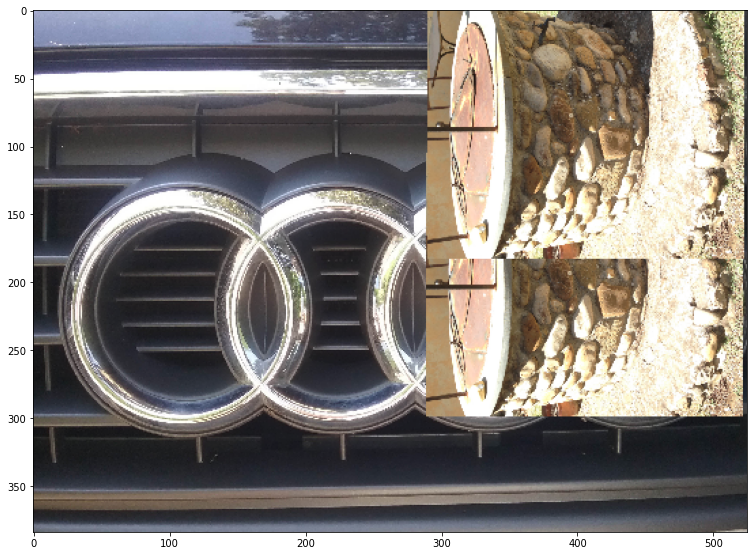

In [15]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
immagine_test = imRead("./testDataset/fake_hm.png")
plt.imshow(immagine_test)

## Calculate the predictions

In [16]:
image_patch = patches(immagine_test,size=128)
imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])

predicted = calculatePredictions(model, image_patch, imageShape)
prediction_patches = predictionPerPatch(predicted, imageShape)
output = patchMean(prediction_patches, imageShape)
del image_patch
del immagine_test

## Plot the output fixing the individual patches 

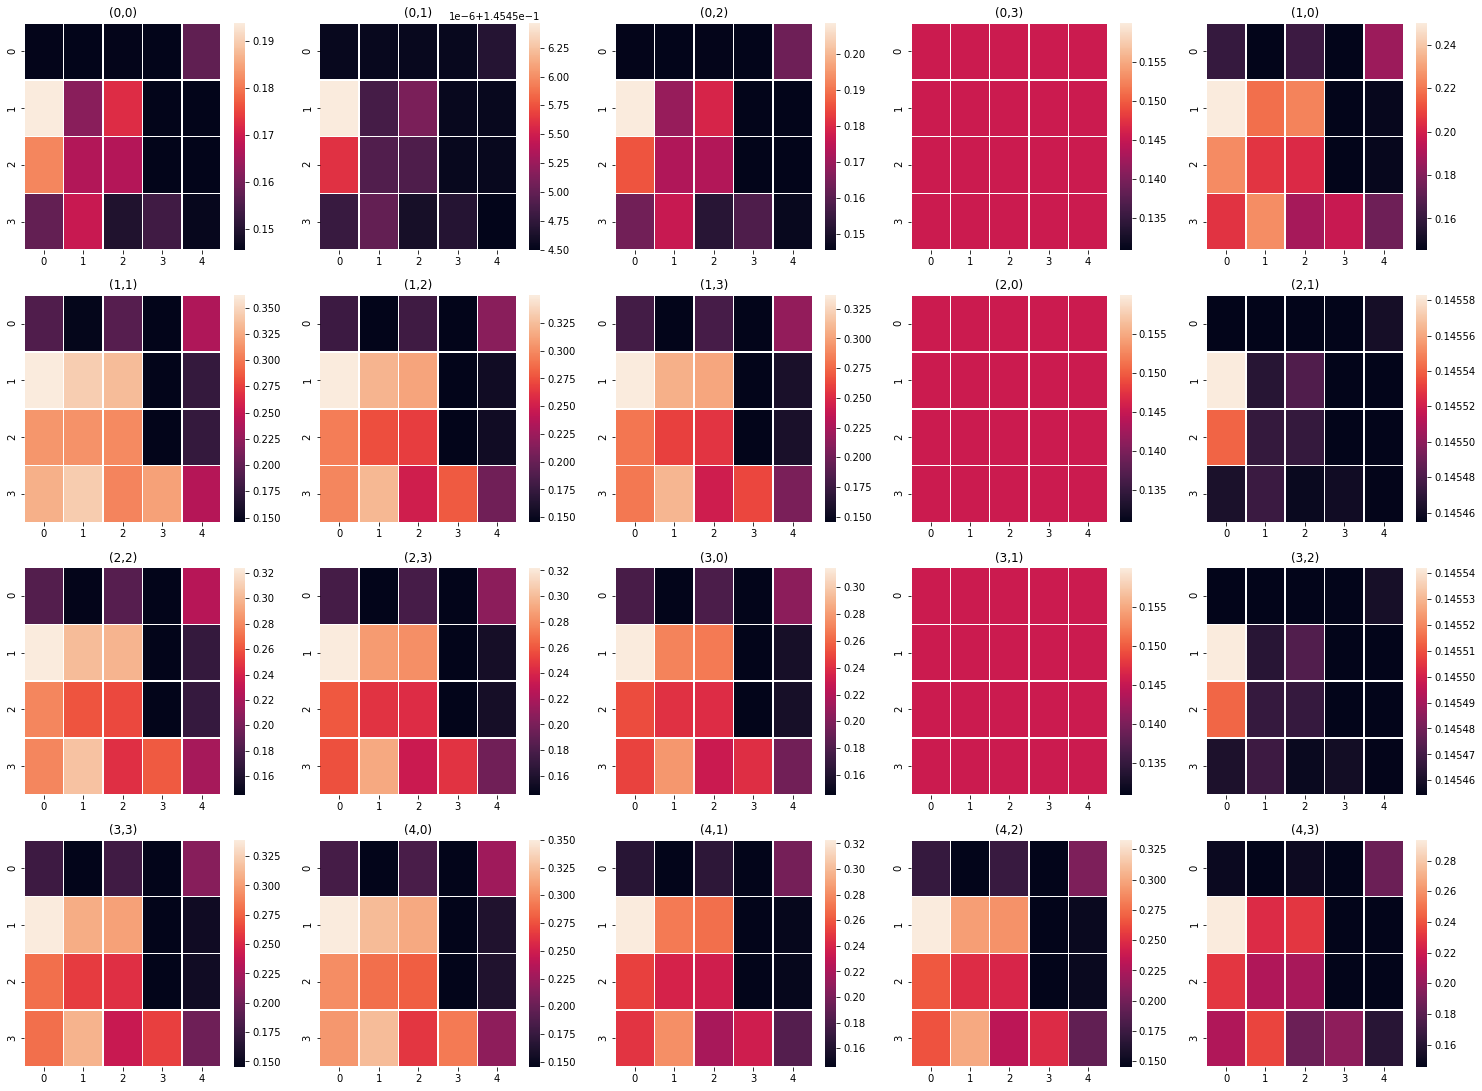

In [22]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

for i in range(np.shape(prediction_patches)[0]):
  plt.subplot(imageShape[0],imageShape[1],i+1), sns.heatmap(prediction_patches[i], linewidth=0.5), plt.title("(" + str(i//imageShape[0]) + "," + str(i%imageShape[0]) + ")")

plt.show()

## Plot the final output

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff9663d4550>,
 Text(0.5, 1.0, 'patch mean'))

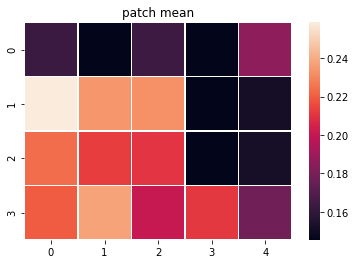

In [19]:
sns.heatmap(output, linewidth=0.5), plt.title("patch mean")

#EXAMPLE 2

---



##Sample image

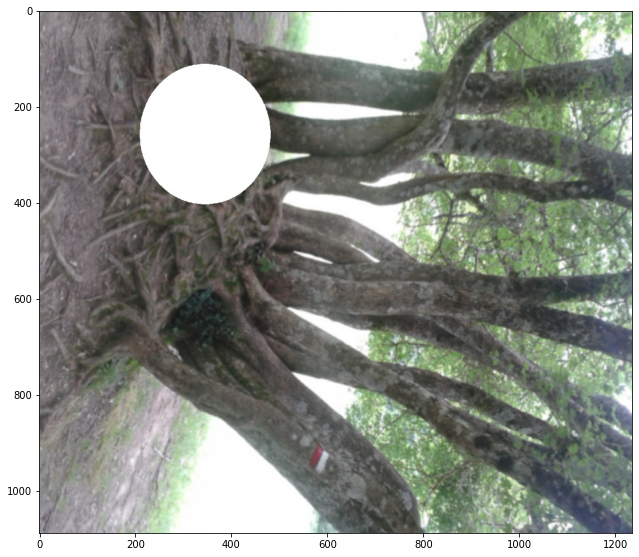

In [23]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
immagine_test = imRead("./testDataset/fake3.jpg")
plt.imshow(immagine_test)

## Calculate the predictions

In [ ]:
image_patch = patches(immagine_test,size=128)
imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])

predicted = calculatePredictions(model, image_patch, imageShape)
prediction_patches = predictionPerPatch(predicted, imageShape)
output = patchMean(prediction_patches, imageShape)
del image_patch
del immagine_test

## Plot the final output

(<matplotlib.axes._subplots.AxesSubplot at 0x7f90dd29cd10>,
 Text(0.5, 1.0, 'patch mean'))

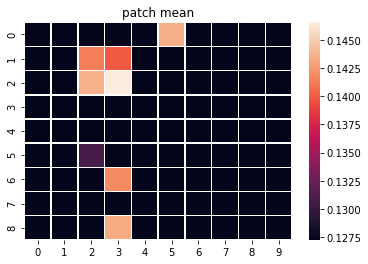

In [ ]:
sns.heatmap(output, linewidth=0.5), plt.title("patch mean")

# EXAMPLE 3 REAL IMAGE


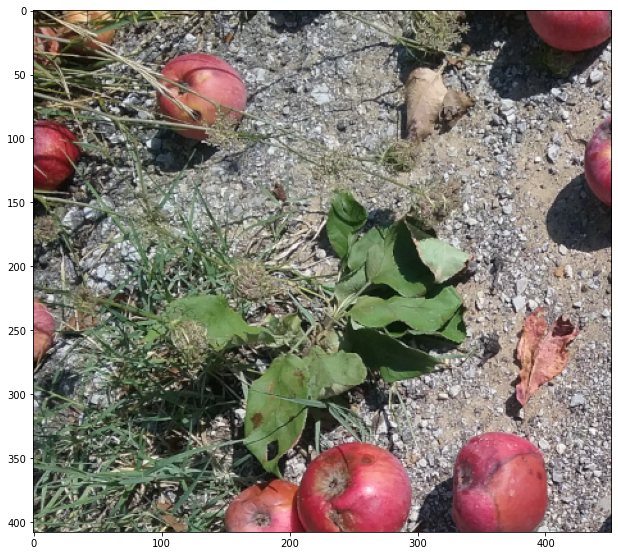

In [24]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
immagine_test = imRead("./testDataset/real_hm3.png")
plt.imshow(immagine_test)

In [25]:
image_patch = patches(immagine_test,size=128)
imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])

predicted = calculatePredictions(model, image_patch, imageShape)
prediction_patches = predictionPerPatch(predicted, imageShape)
output = patchMean(prediction_patches, imageShape)
del image_patch
del immagine_test

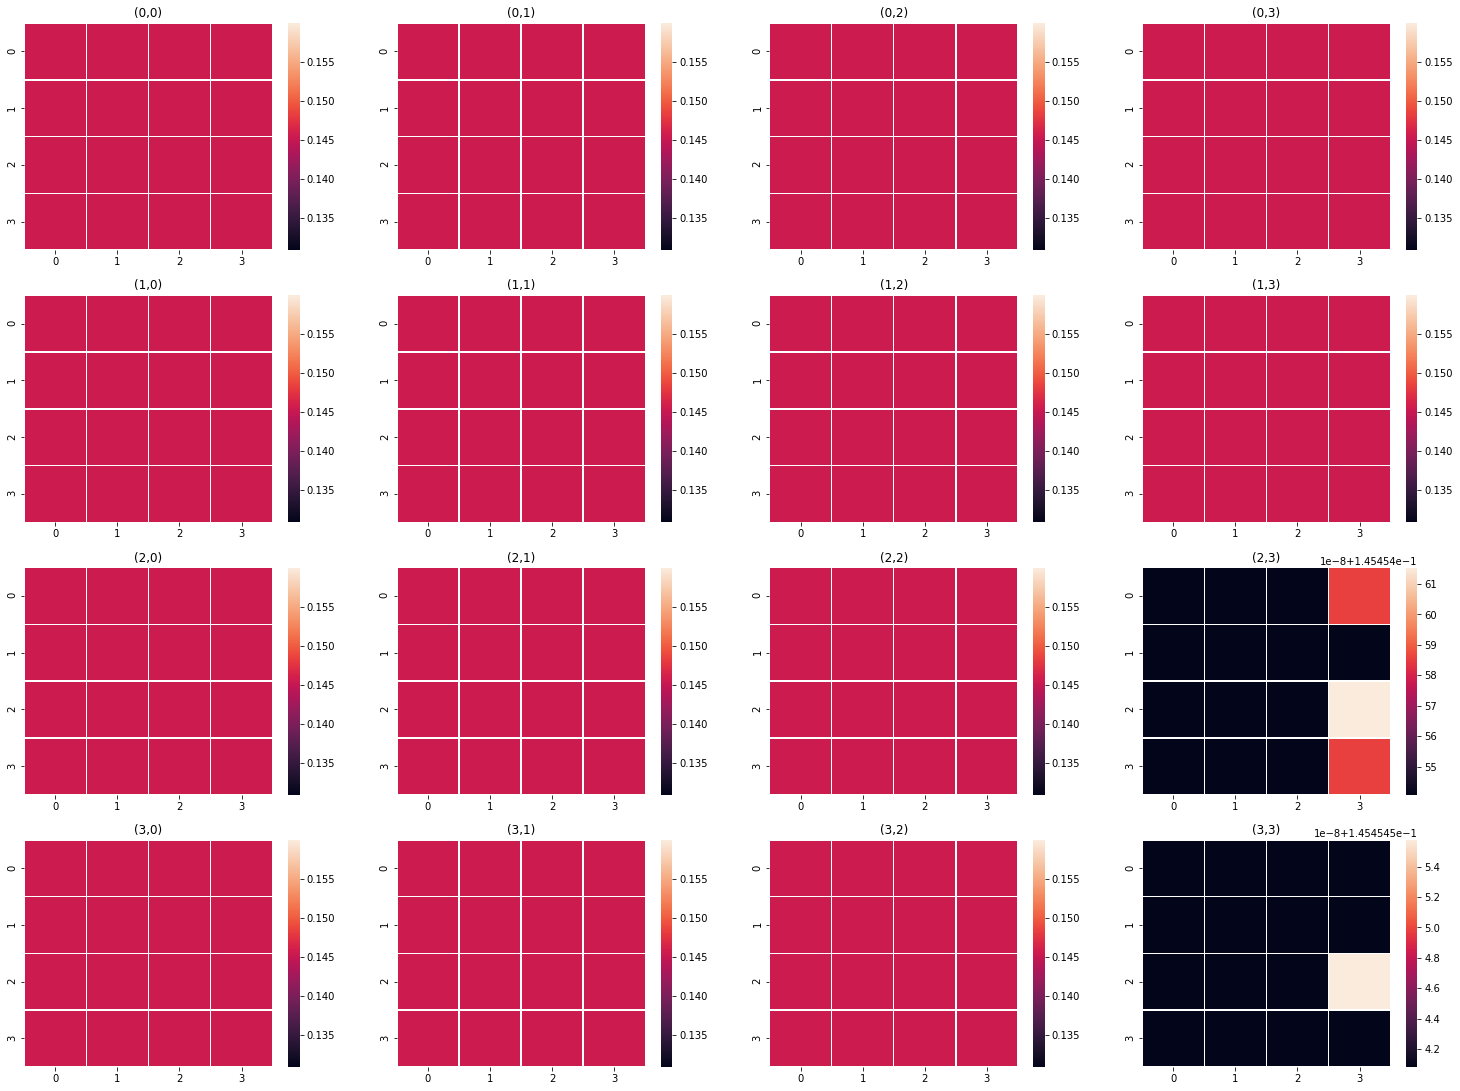

In [26]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

for i in range(np.shape(prediction_patches)[0]):
  plt.subplot(imageShape[0],imageShape[1],i+1), sns.heatmap(prediction_patches[i], linewidth=0.5), plt.title("(" + str(i//imageShape[0]) + "," + str(i%imageShape[0]) + ")")

plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff903328c90>,
 Text(0.5, 1.0, 'patch mean'))

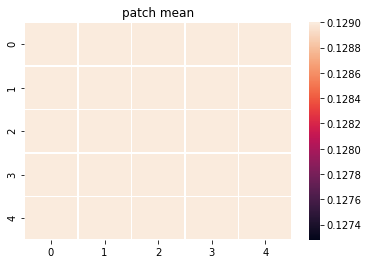

In [38]:
sns.heatmap(output, linewidth=0.5, vmin=0.12728, vmax=0.129 ), plt.title("patch mean")

# EXAMPLE 4 FAKE IMAGE

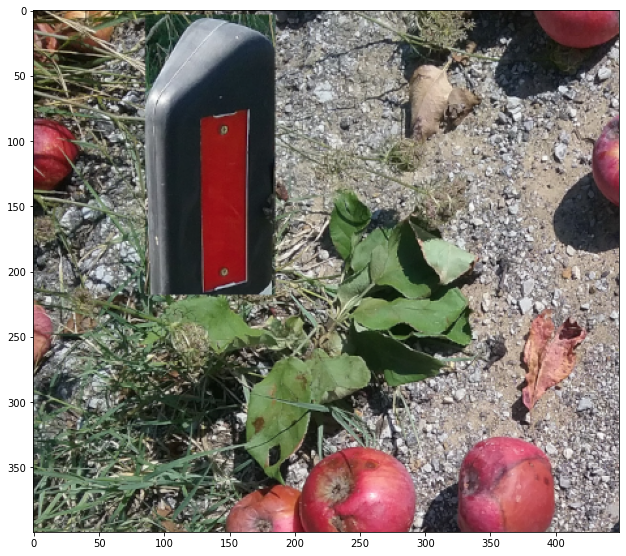

In [28]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
immagine_test = imRead("./testDataset/fake_hm3.png")
plt.imshow(immagine_test)

In [29]:
image_patch = patches(immagine_test,size=128)
imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])

predicted = calculatePredictions(model, image_patch, imageShape)
prediction_patches = predictionPerPatch(predicted, imageShape)
output = patchMean(prediction_patches, imageShape)
del image_patch
del immagine_test

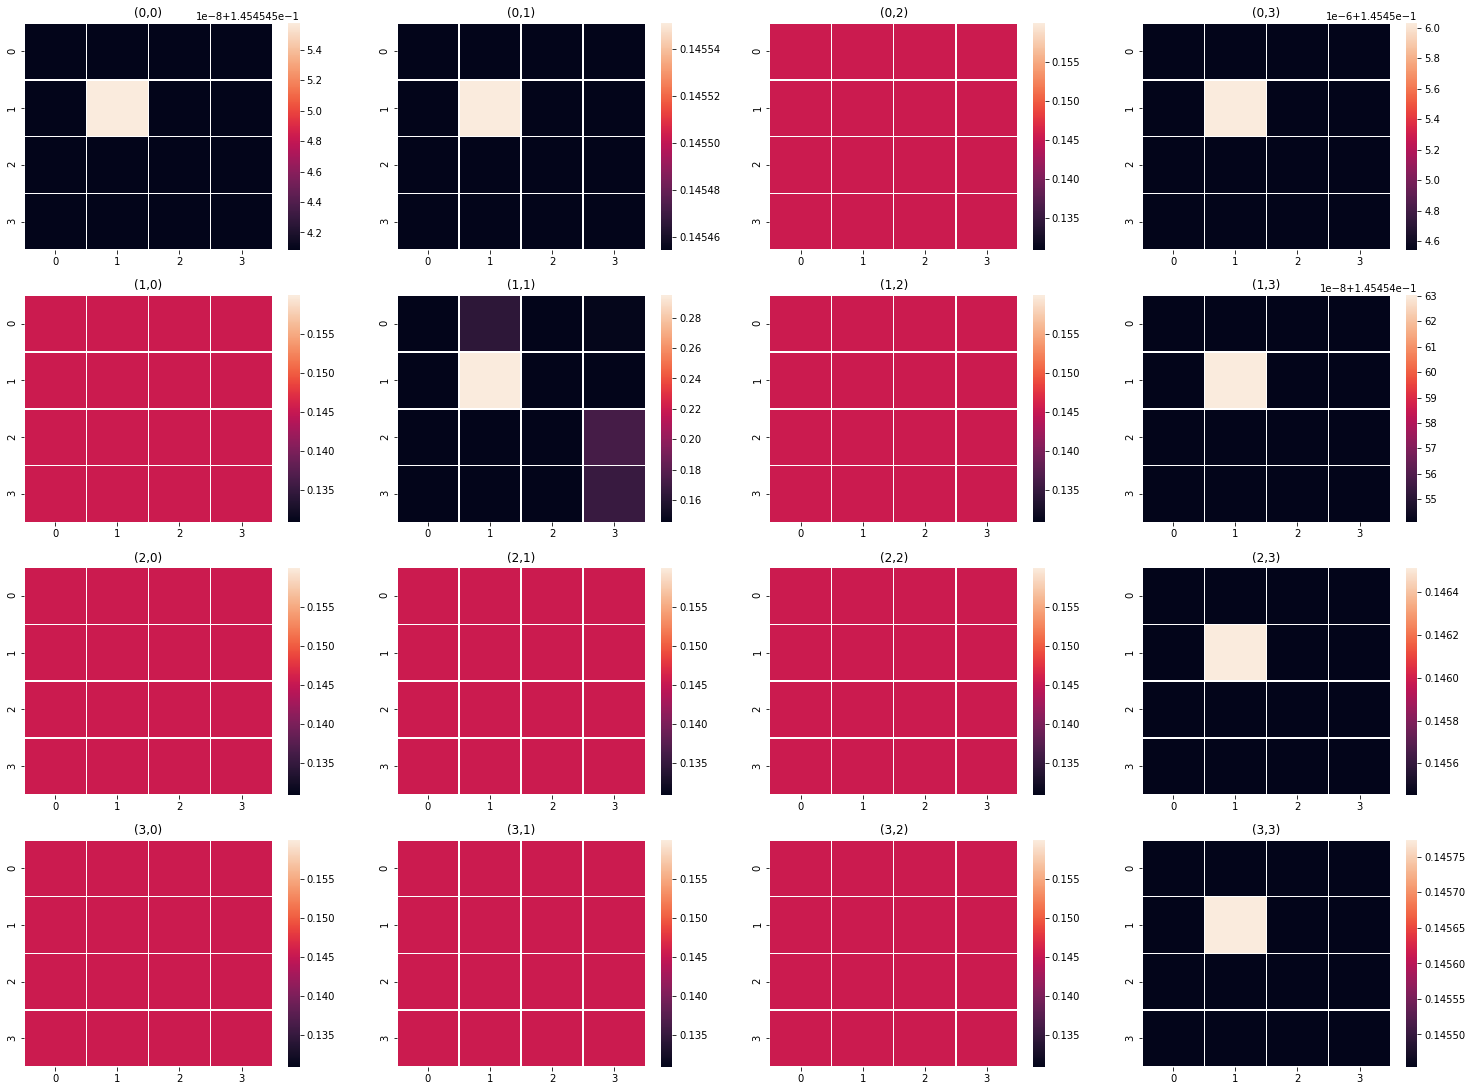

In [30]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

for i in range(np.shape(prediction_patches)[0]):
  plt.subplot(imageShape[0],imageShape[1],i+1), sns.heatmap(prediction_patches[i], linewidth=0.5), plt.title("(" + str(i//imageShape[0]) + "," + str(i%imageShape[0]) + ")")

plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff903741f50>,
 Text(0.5, 1.0, 'patch mean'))

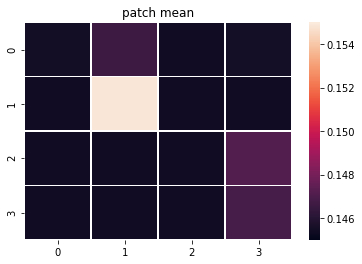

In [31]:
sns.heatmap(output, linewidth=0.5, vmin=0.145, vmax=0.155), plt.title("patch mean")

# EXAMPLE 5 FAKE IMAGE 

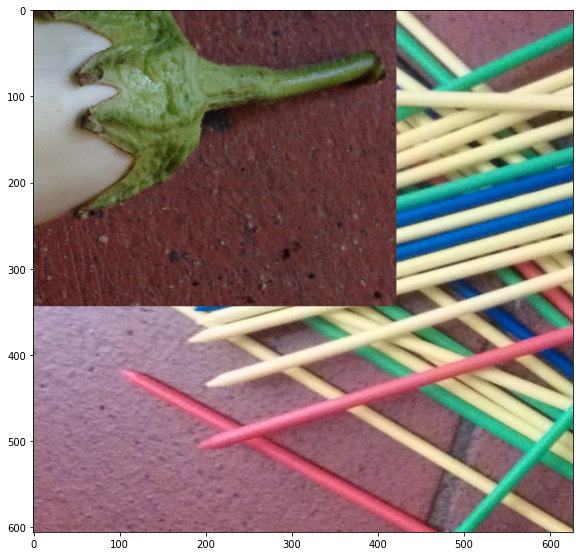

In [32]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
immagine_test = imRead("./testDataset/fake_hm5.png")
plt.imshow(immagine_test)

In [33]:
image_patch = patches(immagine_test,size=128)
imageShape = (np.shape(image_patch)[0], np.shape(image_patch)[1])

predicted = calculatePredictions(model, image_patch, imageShape)
prediction_patches = predictionPerPatch(predicted, imageShape)
output = patchMean(prediction_patches, imageShape)
del image_patch
del immagine_test

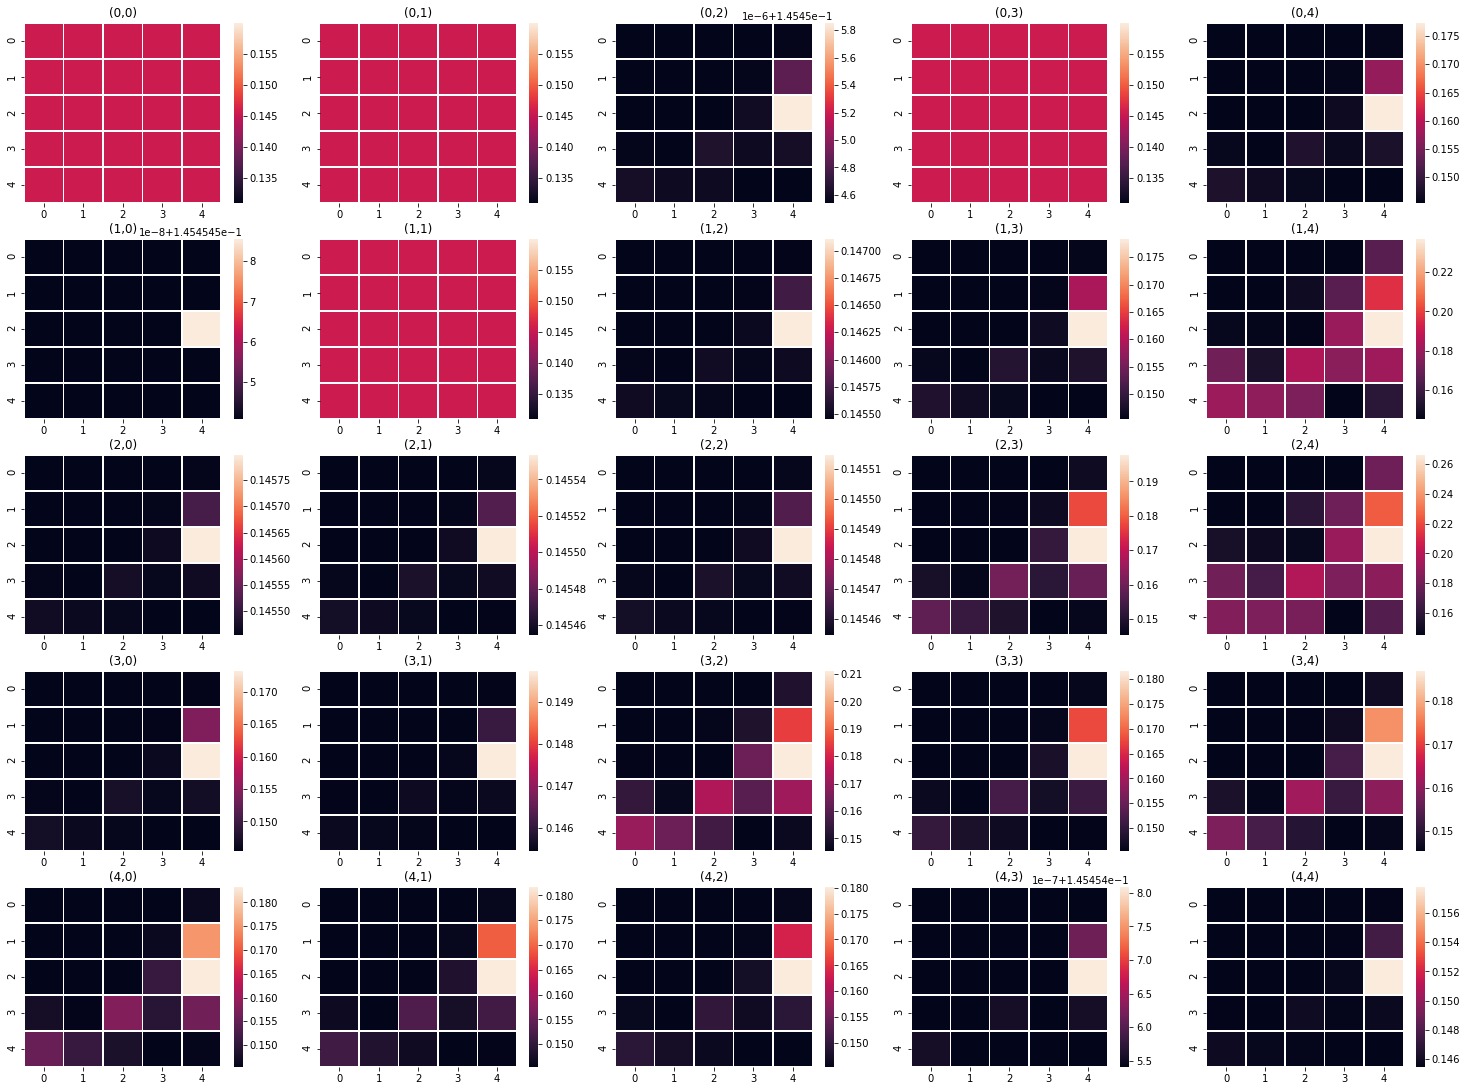

In [34]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

for i in range(np.shape(prediction_patches)[0]):
  plt.subplot(imageShape[0],imageShape[1],i+1), sns.heatmap(prediction_patches[i], linewidth=0.5), plt.title("(" + str(i//imageShape[0]) + "," + str(i%imageShape[0]) + ")")

plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff8ff39d810>,
 Text(0.5, 1.0, 'patch mean'))

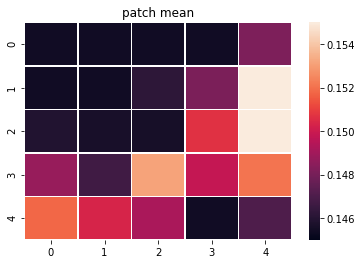

In [35]:
sns.heatmap(output, linewidth=0.5, vmin=0.145, vmax=0.155), plt.title("patch mean")